<a href="https://colab.research.google.com/github/MohamedOsama16/Iris-Classification/blob/main/MDS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Description

This data sets consists of 3 different types of irises’ (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray.

The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width.

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other. Fisher's paper was published in the Annals of Eugenics

In [1]:
!pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score,roc_curve
from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import ttest_ind
import itertools

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import load_iris
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [4]:
iris = load_iris()
data = iris.data
target = iris.target

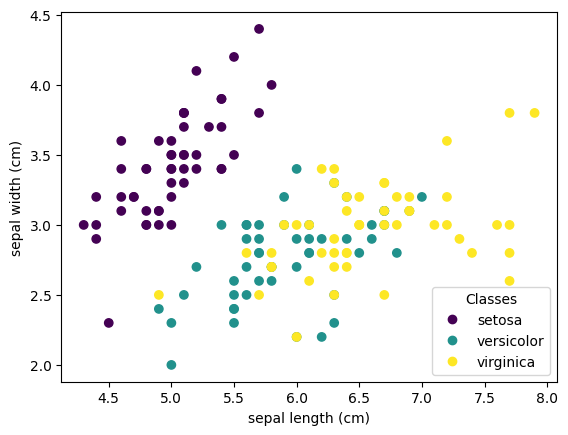

In [5]:
_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

In [6]:
columns = iris.feature_names
iris_df = pd.DataFrame(data, columns=columns)

In [7]:
iris_df['species'] = target

In [8]:
iris_df['species'] = iris_df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

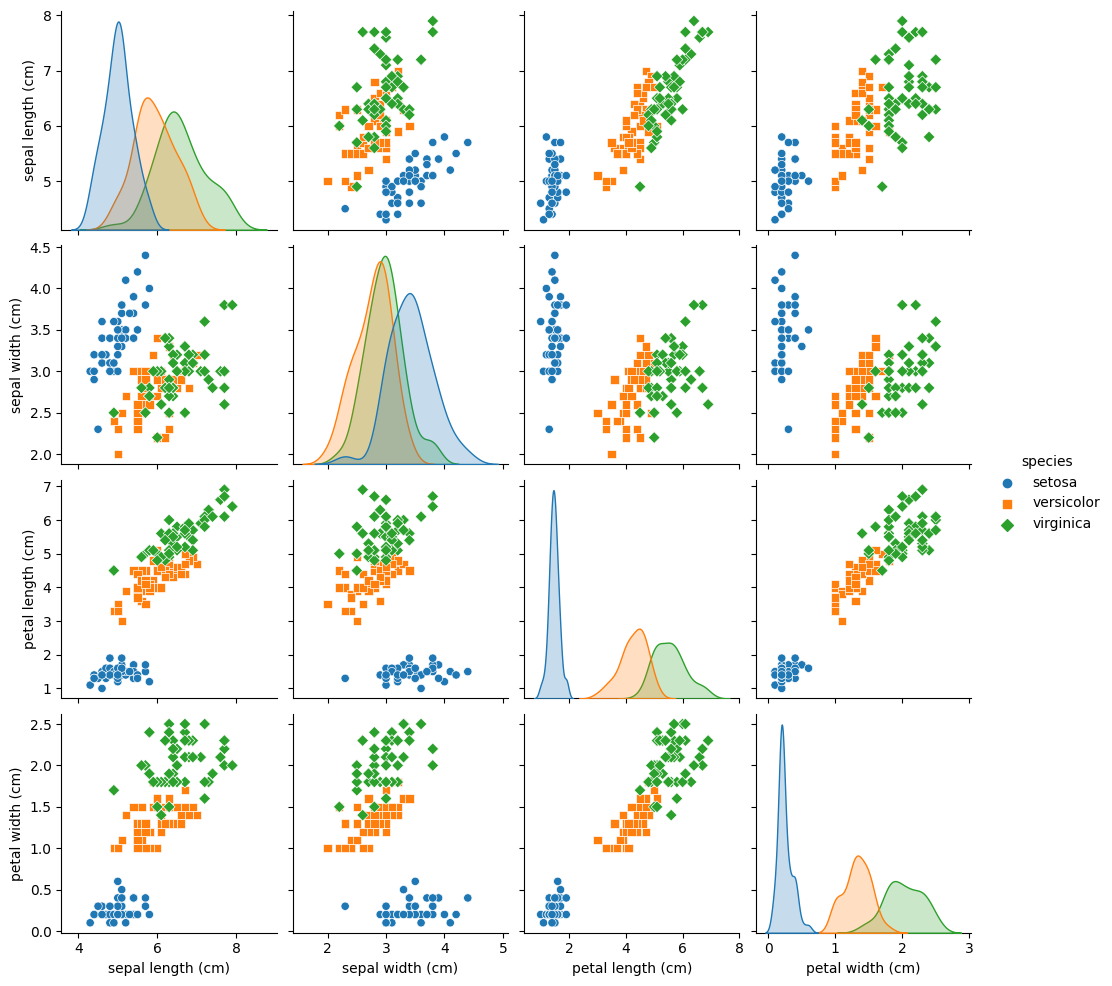

In [9]:
# Pairplot for pairwise relationships in the dataset
sns.pairplot(iris_df, hue="species", markers=["o", "s", "D"])
plt.show()

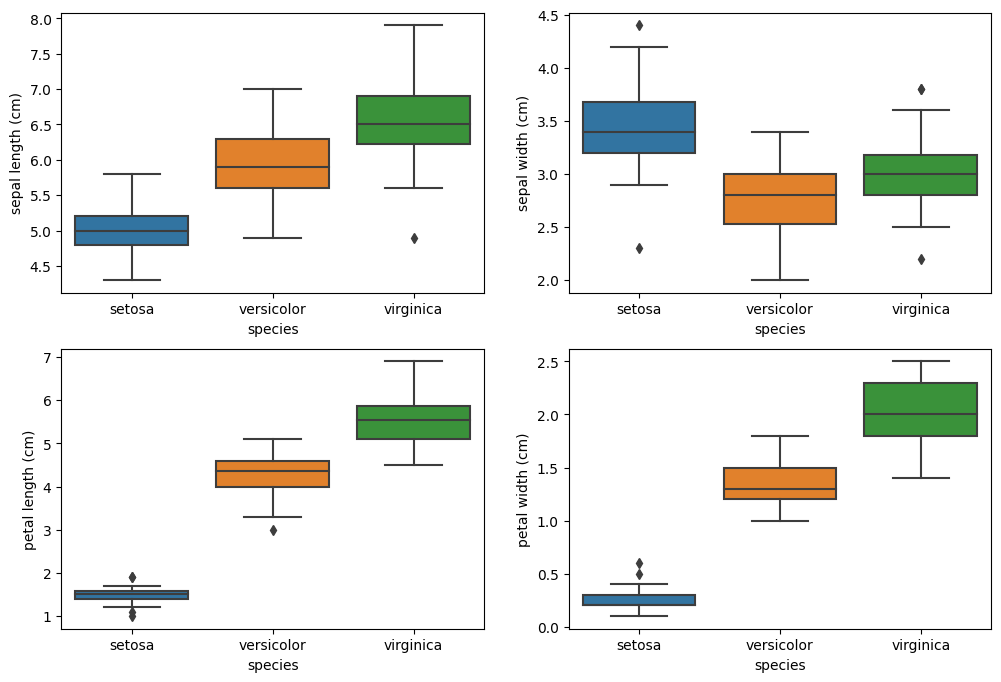

In [10]:
# Boxplot for each feature across species
plt.figure(figsize=(12, 8))
for i, feature in enumerate(columns):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x="species", y=feature, data=iris_df)
plt.show()

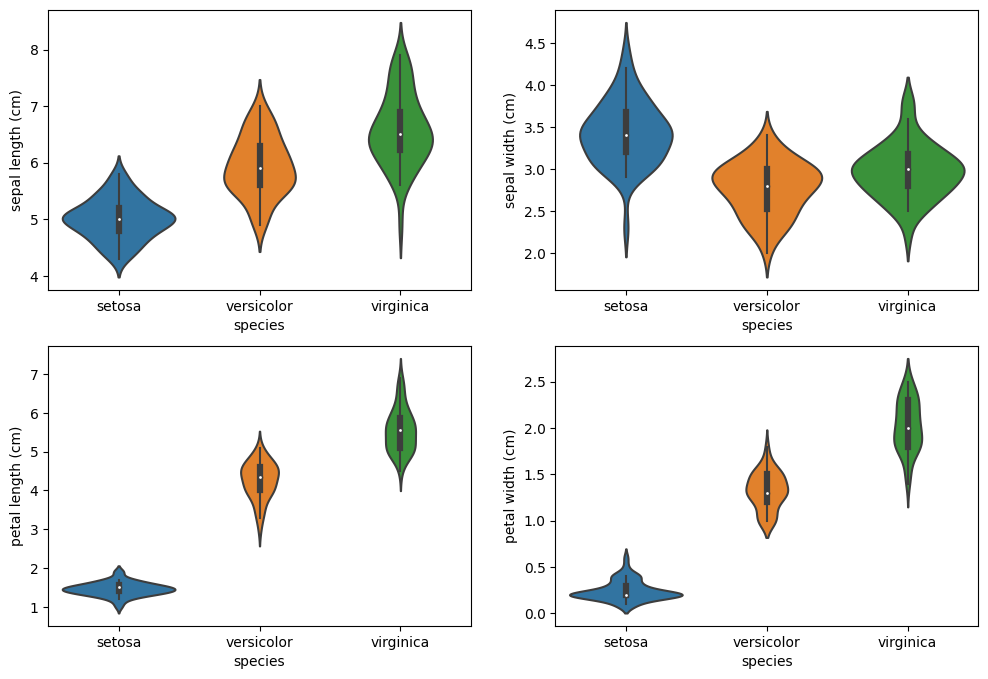

In [11]:
# Violin plot for a combined view of distribution and box plot
plt.figure(figsize=(12, 8))
for i, feature in enumerate(columns):
    plt.subplot(2, 2, i+1)
    sns.violinplot(x="species", y=feature, data=iris_df)
plt.show()

<ipython-input-12-80d14753e62d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(iris_df.corr(), annot=True, cmap="coolwarm")


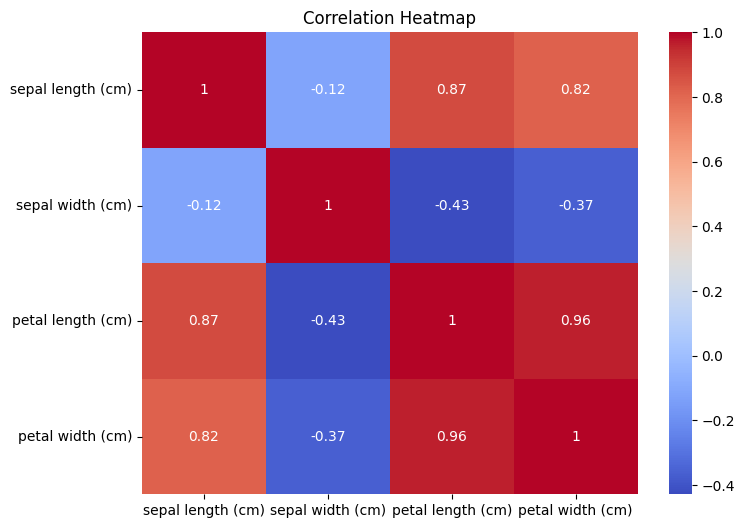

In [12]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(iris_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# Checking and Handling Nulls

In [13]:
iris_df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

In [14]:
iris_no_nulls = iris_df.fillna(iris_df.mean())

<ipython-input-14-b20b646d7b3c>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  iris_no_nulls = iris_df.fillna(iris_df.mean())


# Binning

In [15]:
iris_for_binning = iris_no_nulls.copy()

In [16]:
# Binning the sepal length into categories by Equal Width Binning (Uniform Width)
labels = ['Short', 'Medium', 'Long']  # Define bin labels

iris_for_binning['sepal_length_category'] = pd.cut(iris_for_binning['sepal length (cm)'], bins=3, labels=labels)
iris_for_binning['sepal_width_category'] = pd.cut(iris_for_binning['sepal width (cm)'], bins=3, labels=labels)
iris_for_binning['petal_length_category'] = pd.cut(iris_for_binning['petal length (cm)'], bins=3, labels=labels)
iris_for_binning['petal_width_category'] = pd.cut(iris_for_binning['petal width (cm)'], bins=3, labels=labels)

In [17]:
print(iris_for_binning.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species sepal_length_category sepal_width_category petal_length_category  \
0  setosa                 Short               Medium                 Short   
1  setosa                 Short               Medium                 Short   
2  setosa                 Short               Medium                 Short   
3  setosa                 Short               Medium                 Short   
4  setosa                 Short               Medium                 Short   

  petal_width_category  
0                Short  
1     

# Data Analysis 1

In [18]:
# Data Analysis
analysis_result = iris_no_nulls.describe().transpose().reset_index()
analysis_result = analysis_result.rename(columns={'index': 'Feature'})
analysis_result['Skewness'] = iris_no_nulls.skew()
analysis_result['Kurtosis'] = iris_no_nulls.kurtosis()

<ipython-input-18-eb6e25852344>:4: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  analysis_result['Skewness'] = iris_no_nulls.skew()
<ipython-input-18-eb6e25852344>:5: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  analysis_result['Kurtosis'] = iris_no_nulls.kurtosis()


In [19]:
print(analysis_result)

             Feature  count      mean       std  min  25%   50%  75%  max  \
0  sepal length (cm)  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9   
1   sepal width (cm)  150.0  3.057333  0.435866  2.0  2.8  3.00  3.3  4.4   
2  petal length (cm)  150.0  3.758000  1.765298  1.0  1.6  4.35  5.1  6.9   
3   petal width (cm)  150.0  1.199333  0.762238  0.1  0.3  1.30  1.8  2.5   

   Skewness  Kurtosis  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  


# Data Analysis 2

In [20]:
# List of unique class labels
class_labels = np.unique(target)

# Perform pairwise T-tests for sepal length
for class_pair in itertools.combinations(class_labels, 2):
    class_1, class_2 = class_pair

    # Extract the sepal length for the two classes
    sepal_length_class_1 = data[target == class_1, 0]
    sepal_length_class_2 = data[target == class_2, 0]

    # Perform the T-test for independent samples
    t_statistic, p_value = ttest_ind(sepal_length_class_1, sepal_length_class_2)

    # Print results
    print(f"T-test between class {class_1} and class {class_2}:")
    print("T-statistic:", t_statistic)
    print("P-value:", p_value)
    print()

T-test between class 0 and class 1:
T-statistic: -10.52098626754911
P-value: 8.985235037487079e-18

T-test between class 0 and class 2:
T-statistic: -15.386195820079404
P-value: 6.892546060674059e-28

T-test between class 1 and class 2:
T-statistic: -5.629165259719801
P-value: 1.7248563024547942e-07



In [21]:
# Covariance matrix
covariance_matrix = iris_no_nulls.cov()
print(covariance_matrix)

                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           0.685694         -0.042434           1.274315   
sepal width (cm)           -0.042434          0.189979          -0.329656   
petal length (cm)           1.274315         -0.329656           3.116278   
petal width (cm)            0.516271         -0.121639           1.295609   

                   petal width (cm)  
sepal length (cm)          0.516271  
sepal width (cm)          -0.121639  
petal length (cm)          1.295609  
petal width (cm)           0.581006  


<ipython-input-21-c8c1f713d5f4>:2: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  covariance_matrix = iris_no_nulls.cov()


In [22]:
# Correlation matrix
correlation_matrix = iris_no_nulls.corr()
print(correlation_matrix)

                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000  


<ipython-input-22-ddf73c2cf924>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = iris_no_nulls.corr()


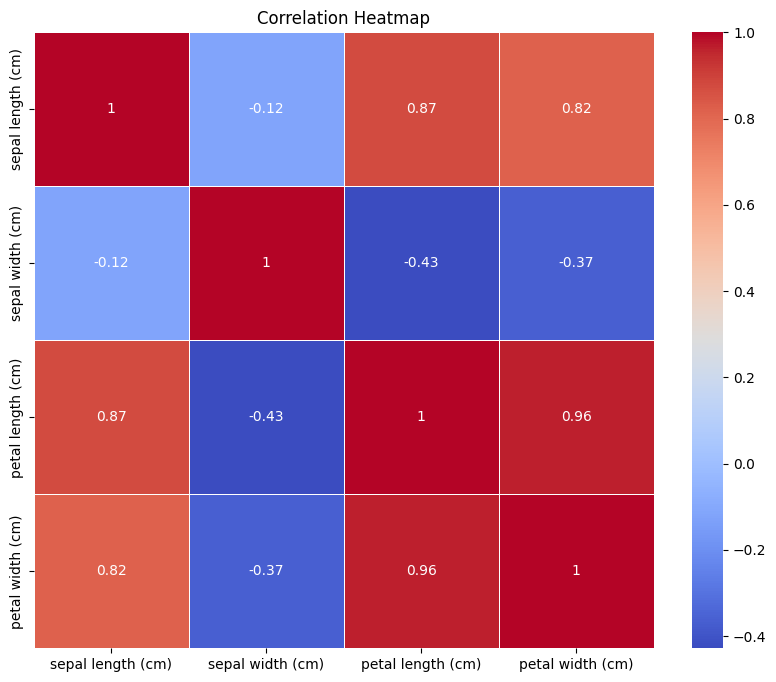

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [24]:
# Initialize an empty matrix to store the results
chi2_results = pd.DataFrame(index=iris_no_nulls.columns[:-1], columns=['Chi2_stat', 'P-value'])

# Loop through each numeric column (excluding the target column)
for column in iris_no_nulls.columns[:-1]:
    # Create a contingency table
    contingency_table = pd.crosstab(iris_no_nulls[column], iris_no_nulls['species'])

    # Perform the chi-square test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

    # Store the results in the matrix
    chi2_results.loc[column] = [chi2_stat, p_value]

# Display the matrix of results
print("Chi-square test results matrix:")
print(chi2_results)

Chi-square test results matrix:
                    Chi2_stat  P-value
sepal length (cm)  156.266667      0.0
sepal width (cm)    89.546287  0.00006
petal length (cm)       271.8      0.0
petal width (cm)       271.75      0.0


In [25]:
# Initialize an empty matrix to store the results
anova_results = pd.DataFrame(index=iris_no_nulls.columns[:-1], columns=['F-statistic', 'P-value'])

# Loop through each numeric column (excluding the target column)
for column in iris_no_nulls.columns[:-1]:
    # Check for missing values in the column
    if iris_no_nulls[column].isnull().any():
        print(f"Column '{column}' contains missing values. ANOVA results are not meaningful.")
        continue

    # Perform one-way ANOVA
    if iris_no_nulls[column].nunique() > 1:  # Check for variation in the column
        anova_result = f_oneway(iris_no_nulls[column][iris_no_nulls['species'] == 0],
                                 iris_no_nulls[column][iris_no_nulls['species'] == 1],
                                 iris_no_nulls[column][iris_no_nulls['species'] == 2])

        # Store the results in the matrix
        anova_results.loc[column] = [anova_result.statistic, anova_result.pvalue]
    else:
        print(f"Column '{column}' has constant values. ANOVA results are not meaningful.")

# Display the matrix of results
print("One-way ANOVA results matrix:")
print(anova_results)

One-way ANOVA results matrix:
                  F-statistic P-value
sepal length (cm)         NaN     NaN
sepal width (cm)          NaN     NaN
petal length (cm)         NaN     NaN
petal width (cm)          NaN     NaN


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [26]:
# One-way ANOVA (using petal length and target)
anova_result = f_oneway(iris_no_nulls['petal length (cm)'][iris_no_nulls['species'] == 0],
                         iris_no_nulls['petal length (cm)'][iris_no_nulls['species'] == 1],
                         iris_no_nulls['petal length (cm)'][iris_no_nulls['species'] == 2])

print("One-way ANOVA result:")
print(anova_result)

One-way ANOVA result:
F_onewayResult(statistic=nan, pvalue=nan)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [27]:
features = pd.DataFrame(data, columns=columns)
labels = pd.DataFrame(target)

# Standarization

In [28]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
y = labels

# Spliting

In [29]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Feature Reduction

LDA

In [30]:
# Apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PCA

In [31]:
# Apply Principal Component Analysis
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

SVD

In [32]:
# Perform Singular Value Decomposition (SVD)
U, S, VT = np.linalg.svd(X_scaled, full_matrices=False)

# Choose the number of components to retain (e.g., 2)
num_components = 2

# Reduce dimensionality by selecting top components
X_reduced_SVD = np.dot(U[:, :num_components], np.diag(S[:num_components]))


# Naive Bayesian with 0.8 train and 0.2 test

In [33]:
# Create a Naive Bayes classifier (Gaussian Naive Bayes for continuous features)
nb_classifier = GaussianNB()

In [34]:
# Train the classifier
nb_classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [35]:
# Make predictions on the test set
NB_y_pred = nb_classifier.predict(X_test)

Evaluate Naive Bayesian model

In [36]:
accuracy = accuracy_score(y_test, NB_y_pred)
conf_matrix = confusion_matrix(y_test, NB_y_pred)
classification_rep = classification_report(y_test, NB_y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

Accuracy: 1.0
Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



# Accuracy - Error rate - Precision - Recall - F_measure

In [37]:
# Calculate error rate
error_rate = 1 - accuracy

# Calculate precision
precision = precision_score(y_test, NB_y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_test, NB_y_pred, average='weighted')

# Calculate F-measure
f_measure = f1_score(y_test, NB_y_pred, average='weighted')

# Print results
print("\nAccuracy:", accuracy)
print("Error Rate:", error_rate)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)


Accuracy: 1.0
Error Rate: 0.0
Precision: 1.0
Recall: 1.0
F-measure: 1.0


# Naive Bayesian with cross validation

In [38]:
# Create a Naive Bayes classifier (Gaussian Naive Bayes for continuous features)
naive_bayes_classifier_CV = GaussianNB()

In [39]:
# Specify the number of folds for cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

In [41]:
# Perform K-fold cross-validation for Naive Bayes classifier
cv_scores = cross_val_score(naive_bayes_classifier_CV, X_scaled, y, cv=kf, scoring='accuracy')


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [42]:
# Print accuracy for each fold
print("Accuracy for each fold:", cv_scores)

# Calculate and print average accuracy
average_accuracy = np.mean(cv_scores)
print(f"Average Accuracy: {average_accuracy}")

Accuracy for each fold: [1.         0.96666667 0.93333333 0.96666667 0.93333333]
Average Accuracy: 0.9600000000000002


# Bayesian Belief Network

In [43]:
# Create a DataFrame from the scaled features and target
data = pd.DataFrame(data=np.c_[X_scaled, y], columns=iris.feature_names + ['target'])

# Split the dataset into training and testing sets using Pandas DataFrame
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [44]:
# Define the structure of the Bayesian Network
model = BayesianModel([('sepal length (cm)', 'target'),
                       ('sepal width (cm)', 'target'),
                       ('petal length (cm)', 'target'),
                       ('petal width (cm)', 'target')])

In [ ]:
# Estimate the parameters of the model
model.fit(train_data, estimator=ParameterEstimator)

In [ ]:
# Make predictions using Variable Elimination
inference = VariableElimination(model)
predicted_values = []

for _, row in test_data.iterrows():
    evidence = {column: row[column] for column in row.index if column != 'target'}
    predicted_value = inference.map_query(variables=['target'], evidence=evidence)['target']
    predicted_values.append(predicted_value)

# Convert the predictions to numpy array
y_pred = np.array(predicted_values)

# Convert the true labels to numpy array
y_true = test_data['target'].values

# Evaluate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Decision Tree

In [63]:
# Create a Decision Tree classifier with Entropy criterion
tree_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)

In [64]:
# Train the Decision Tree classifier
tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [65]:
# Make predictions on the test set
DT_y_pred = tree_classifier.predict(X_test)

Evaluate Decision Tree model

In [66]:
accuracy = accuracy_score(y_test, DT_y_pred)
classification_report_result = classification_report(y_test, DT_y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



# LDA Model

In [67]:
# Create a Linear Discriminant Analysis (LDA) model
lda_model = LinearDiscriminantAnalysis()

In [68]:
# Train the LDA model
lda_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis()

In [69]:
# Make predictions on the test set
LDA_y_pred = lda_model.predict(X_test)

Evaluate LDA model

In [70]:
# Evaluate the model
accuracy = accuracy_score(y_test, LDA_y_pred)
classification_report_result = classification_report(y_test, LDA_y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



# PCA Model

In [71]:
# Create a PCA model
pca_model = PCA(n_components=2)  # Specify the number of components (dimensions)

In [72]:
# Fit and transform the training data
X_train_pca = pca_model.fit_transform(X_train)

In [73]:
# Transform the test data
X_test_pca = pca_model.transform(X_test)

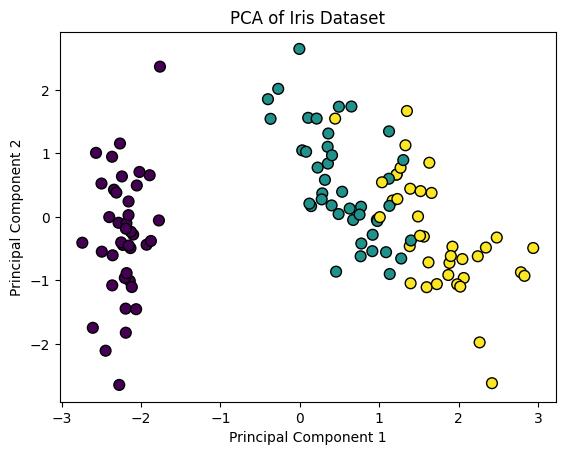

In [74]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=60)
plt.title('PCA of Iris Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Evaluate Logistic model with Data after PCA


In [75]:
# Create a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Train the model on PCA-transformed training data
logreg_model.fit(X_train_pca, y_train)

# Make predictions on PCA-transformed test data
Lgistic_PCA_y_pred = logreg_model.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, Lgistic_PCA_y_pred)
classification_report_result = classification_report(y_test, Lgistic_PCA_y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_result)

Accuracy: 0.9
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.88      0.78      0.82         9
           2       0.83      0.91      0.87        11

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# KNN Model

## KNN classifier with Euclidean distance

In [76]:
knn_euclidean = KNeighborsClassifier(n_neighbors=3)
knn_euclidean.fit(X_train, y_train)
y_pred_euclidean = knn_euclidean.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [77]:
# Evaluate models
accuracy_euclidean = accuracy_score(y_test, y_pred_euclidean)
classification_report_euclidean = classification_report(y_test, y_pred_euclidean)

In [78]:
print("K-NN with Euclidean Distance:")
print(f"Accuracy: {accuracy_euclidean}")
print("Classification Report:\n", classification_report_euclidean)

K-NN with Euclidean Distance:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## KNN classifier with  Manhattan distance

In [80]:
knn_manhattan = KNeighborsClassifier(n_neighbors=3, p=1)
knn_manhattan.fit(X_train, y_train)
y_pred_manhattan = knn_manhattan.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [83]:
print("\nK-NN with Manhattan Distance:")
print(f"Accuracy: {accuracy_manhattan}")
print("Classification Report:\n", classification_report_manhattan)



K-NN with Manhattan Distance:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Nueral Network

In [82]:
accuracy_manhattan = accuracy_score(y_test, y_pred_manhattan)
classification_report_manhattan = classification_report(y_test, y_pred_manhattan)

In [84]:
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(target.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_onehot, test_size=0.2, random_state=42)


In [86]:
# Build a simple neural network model
model = Sequential()
model.add(Dense(8, input_dim=4, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [87]:
# Compile the model
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [88]:
# Train the model
model.fit(X_train, np.argmax(y_train, axis=1), epochs=100, batch_size=8, validation_split=0.1)


Epoch 1/100
14/14 [==============================] - 1s 22ms/step - loss: 1.1037 - accuracy: 0.2963 - val_loss: 1.0836 - val_accuracy: 0.2500
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 1.0499 - accuracy: 0.3981 - val_loss: 1.0537 - val_accuracy: 0.2500
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 1.0011 - accuracy: 0.4352 - val_loss: 1.0237 - val_accuracy: 0.3333
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 0.9589 - accuracy: 0.4722 - val_loss: 0.9952 - val_accuracy: 0.4167
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 0.9199 - accuracy: 0.5093 - val_loss: 0.9705 - val_accuracy: 0.5000
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 0.8847 - accuracy: 0.5463 - val_loss: 0.9455 - val_accuracy: 0.5833
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 0.8515 - accuracy: 0.5741 - val_loss: 0.9244 - val_accuracy: 0.7500
Epoch 8/100


In [89]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, np.argmax(y_test, axis=1))
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

1/1 [==============================] - 0s 30ms/step - loss: 0.1450 - accuracy: 0.9667
Test Loss: 0.1450, Test Accuracy: 0.9667


In [90]:
# Predict probabilities on the test set
y_prob = model.predict(X_test)

1/1 [==============================] - 0s 95ms/step


In [91]:
y_test

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [96]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Predict class probabilities on the test set
y_prob = model.predict(X_test)

# Get the predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


1/1 [==============================] - 0s 38ms/step
Confusion Matrix:
[[10  0  0]
 [ 0  6  3]
 [ 0  0 11]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.67      0.80         9
           2       0.79      1.00      0.88        11

    accuracy                           0.90        30
   macro avg       0.93      0.89      0.89        30
weighted avg       0.92      0.90      0.90        30



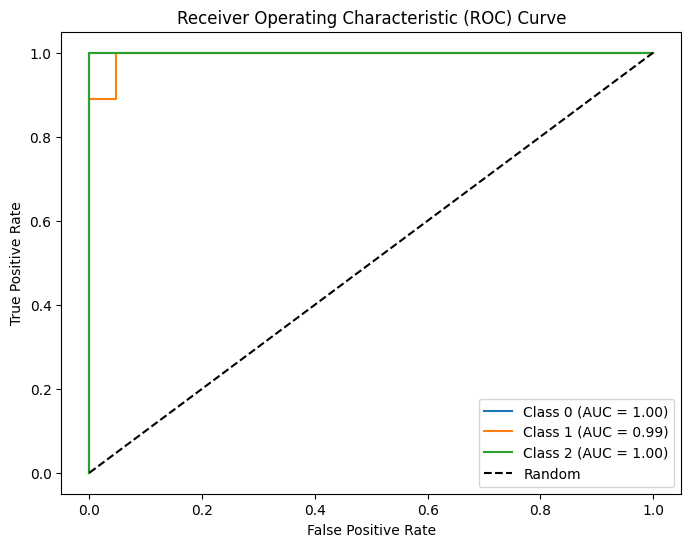

In [95]:
# Get ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # Three classes in the Iris dataset
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Predict class probabilities on the test set
y_prob = model.predict(X_test)

# Get the predicted class indices
y_pred = np.argmax(y_prob, axis=1)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


# References

https://archive.ics.uci.edu/dataset/53/iris

scipy.stats.ttest_ind

sklearn.datasets.load_iris

numpy.unique

itertools.combinations

In [97]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [98]:
# Install Git
!apt-get install -y git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [99]:
!git clone https://github.com/MohamedOsama16/Iris-Classification.git

Cloning into 'Iris-Classification'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [100]:
!cp /content/drive/MDS_Project.ipynb /content/Iris-Classification/


cp: cannot stat '/content/drive/MDS_Project.ipynb': No such file or directory
